In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from graph_cut import BoykovKolmorogov
from img_to_graph import img_to_graph
from utils import get_mask, process_mask
from GUI import GUI_seeds
import os
from tqdm import tqdm

In [2]:
inputfile = '../img/mario_in/mario_in_30.JPG'

marked_ob_pixels [(204, 318), (205, 318), (207, 318), (208, 318), (209, 318), (210, 318), (211, 318), (212, 318), (213, 318), (214, 318), (215, 317), (216, 317), (217, 317), (218, 317), (219, 317), (220, 317), (221, 317), (222, 317), (223, 317), (224, 317), (226, 317), (227, 317), (228, 317), (229, 318), (230, 318), (231, 318), (232, 318), (233, 318), (234, 318), (235, 318), (236, 318), (238, 318), (239, 318), (240, 318), (241, 319), (242, 320), (243, 320), (245, 320), (246, 320), (248, 320), (249, 320), (251, 320), (252, 320), (253, 320), (254, 320), (255, 320), (256, 320), (257, 320), (259, 320), (260, 320), (261, 320), (262, 320), (263, 321), (264, 321), (265, 321), (266, 321), (267, 321), (268, 321), (269, 321), (268, 287), (268, 288), (268, 289), (268, 290), (268, 291), (267, 291), (267, 292), (267, 293), (267, 294), (266, 295), (265, 295), (265, 296), (265, 297), (265, 298), (265, 299), (265, 300), (265, 301), (266, 302), (266, 304), (266, 305), (266, 306), (266, 307), (266, 308)

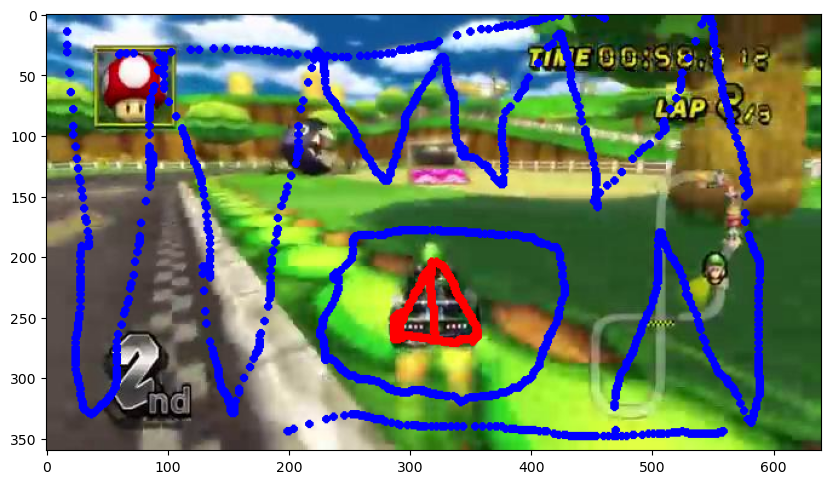

In [13]:
GUI = GUI_seeds(inputfile)
marked_ob_pixels, marked_bg_pixels, labelled_image = GUI.labelling()
print("marked_ob_pixels", marked_ob_pixels)
print("marked_bg_pixels", marked_bg_pixels)
plt.figure(figsize=(10,15))
plt.imshow(labelled_image[...,::-1])
plt.show()

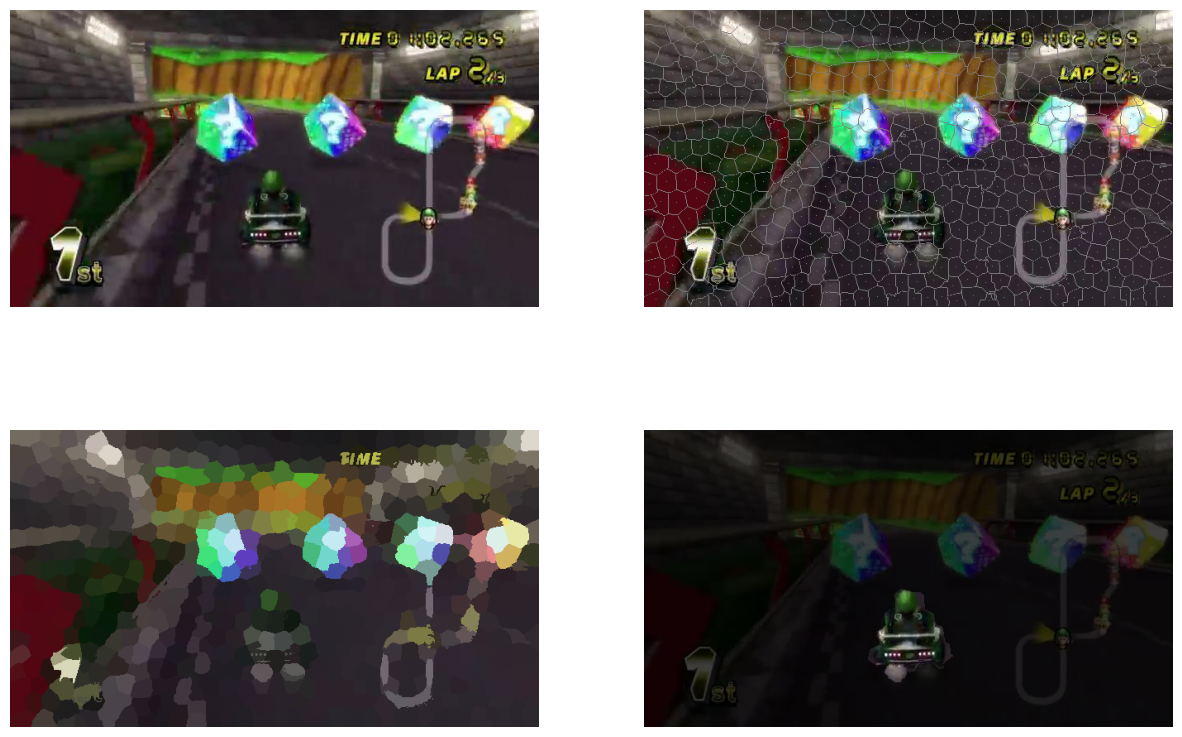

In [11]:
image = cv2.imread('../img/mario_in/mario_in_35.JPG')
G, s, t, I_marked, sp_lab = img_to_graph(image, marked_ob_pixels, marked_bg_pixels, region_size=20)
G_residual = BoykovKolmorogov(G, s, t, capacity='sim').max_flow()

mask = get_mask(image, G, G_residual)
mask = process_mask(mask, 2000)
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Final = np.where(mask, image, image // 4)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.tick_params(labelcolor='black', top='off', bottom='off', left='off', right='off')
plt.imshow(image[...,::-1])
plt.axis("off")
plt.xlabel("Input image")

plt.subplot(2,2,2)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.imshow(I_marked[...,::-1])
plt.axis("off")
plt.xlabel("Super-pixel boundaries and centroid")

plt.subplot(2,2,3)
plt.imshow(sp_lab)
plt.axis("off")
plt.xlabel("Super-pixel representation")

plt.subplot(2,2,4)
plt.imshow(Final[...,::-1])
plt.axis("off")
plt.xlabel("Output Image")

plt.show()

In [18]:
def iterate_frames(video_path, start_time, end_time, num_frames, output_folder, threshold):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    previous_mask = None

    for i in tqdm(range(num_frames)):
        ret, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i * (end_frame - start_frame) // num_frames)
        if ret:
            try:
                G, s, t, _, _ = img_to_graph(frame, marked_ob_pixels, marked_bg_pixels, region_size=20)
                G_residual = BoykovKolmorogov(G, s, t, capacity='sim').max_flow()

                current_mask = get_mask(frame, G, G_residual)
                if previous_mask is not None:
                    mask = cv2.bitwise_and(previous_mask, current_mask)
                    previous_mask = current_mask
                else:
                    mask = current_mask
                    previous_mask = current_mask

                # change shape to (height, width, 3)
                mask = process_mask(mask, threshold)
                mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
                image_mask = np.where(mask == 1, frame, frame//4)

                filename = f'mario_{i}.JPG'
                filepath = os.path.join(output_folder, filename)
                cv2.imwrite(filepath, image_mask)
            except:
                print(f"Error processing frame {i}")
        else:
            print("Fin de la vidéo.")
            break
    cap.release()


video_path = '../video/Mario_Kart.mp4'
start = 60 + 15
delta = 50

# 23 à 63

fps = 5
output_folder = '../img/mario_out_gc2/'
threshold = 2500

# create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

iterate_frames(video_path, start, start+delta, delta*fps, output_folder, threshold)


100%|██████████| 200/200 [13:37<00:00,  4.09s/it]


In [19]:
import cv2
import os

def create_video(image_folder, video_name, fps, num_frames):
    images = [f'mario_{i}.JPG' for i in range(num_frames)]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

if __name__ == "__main__":
    image_folder = "../img/mario_out_gc2/"
    video_name = "../img/mario_out_gc2/output_video.mp4"

    create_video(image_folder, video_name, fps, delta*fps)


In [84]:
images = [f'../img/mario_out_gc/mario_{i}.JPG' for i in range(len([img for img in os.listdir(image_folder) if img.endswith(".JPG")]))]
print(images)

['../img/mario_out_gc/mario_0.JPG', '../img/mario_out_gc/mario_1.JPG', '../img/mario_out_gc/mario_2.JPG', '../img/mario_out_gc/mario_3.JPG', '../img/mario_out_gc/mario_4.JPG', '../img/mario_out_gc/mario_5.JPG', '../img/mario_out_gc/mario_6.JPG', '../img/mario_out_gc/mario_7.JPG', '../img/mario_out_gc/mario_8.JPG', '../img/mario_out_gc/mario_9.JPG', '../img/mario_out_gc/mario_10.JPG', '../img/mario_out_gc/mario_11.JPG', '../img/mario_out_gc/mario_12.JPG', '../img/mario_out_gc/mario_13.JPG', '../img/mario_out_gc/mario_14.JPG', '../img/mario_out_gc/mario_15.JPG', '../img/mario_out_gc/mario_16.JPG', '../img/mario_out_gc/mario_17.JPG', '../img/mario_out_gc/mario_18.JPG', '../img/mario_out_gc/mario_19.JPG', '../img/mario_out_gc/mario_20.JPG', '../img/mario_out_gc/mario_21.JPG', '../img/mario_out_gc/mario_22.JPG', '../img/mario_out_gc/mario_23.JPG', '../img/mario_out_gc/mario_24.JPG', '../img/mario_out_gc/mario_25.JPG', '../img/mario_out_gc/mario_26.JPG', '../img/mario_out_gc/mario_27.JPG', '